# Hospitalization Prediction for Elderly People


In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, classification_report, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, PowerTransformer

from src.eda import *
from src.config import *
from src.data_extract import *
from src import feature_selection as fs
from src.evaluation import *


# 1. Data Extraction


* *The Mexican Health and Aging Study* (**MHAS**) is a dataset of household surveys designed to collect information on the health, economic status, and quality of life of older adults.
The survey was conducted over 5 time periods, technically known as **Waves**. 
In addition, there are three study subjects: the respondent (r), the spouse (s), and the household (H). For this study, only the first two were used.



## 1.1. Load data

* The data is available on the official **MHAS** site. They are extracted and processed by a **Dataframe**.

In [2]:
mhas = get_data_frame()

Current directory: /home/giraldiego/Desktop/code/workspaces/anyoneai/final_project/Final_Projects
ZIP extracted



## 1.2. Extract data.

* To prepare the data for exploratory analysis (**EDA**) and modeling, common characteristics for the two study subjects are considered and merged into a single data set. 

In [3]:
df = extract(mhas)

/home/giraldiego/Desktop/code/workspaces/anyoneai/final_project/Final_Projects/src/data_extract.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s1[p1] = df[s1].copy()
/home/giraldiego/Desktop/code/workspaces/anyoneai/final_project/Final_Projects/src/data_extract.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s1[p1] = df[s1].copy()
/home/giraldiego/Desktop/code/workspaces/anyoneai/final_project/Final_Projects/src/data_extract.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

# 2. EDA.
* **Data structure**: The data set is divided into 15 sections. Each section quantifies different aspects related to health and socio-economic aspects..

## 2.1. Identification of the target variable
* The target variable belongs to *Section C: Health Care Utilization and Insurance* and is labeled **Medical Care Utilization: Hospital** *`(r/s)#hosp1y`*, where *"r"* refers to "respondent" and *"s"* to "spouse".  Finally, *"#"* goes from 1 to 5 and refers to waves. 

* *rwhosp1y* indicates whether the respondent reports at least one overnight hospital stay in the last 12 months. RwHOSP1Y is coded as 0 if the respondent had no overnight hospital stays, and is coded as 1 if the respondent had at least one overnight hospital stay. 

* *swhosp1y* is taken from the spouse value in wave "w" for *rwhosp1y*. In addition to the special default codes used in *rwhosp1y*, if the respondent is not considered matched in the current cycle and is assumed to be single, a special default value of .u is used. In addition, if the respondent is not considered matched in the current cycle but reports being married, a special default value of .u is used. Similarly, if the respondent is not considered matched in the current cycle but reports being married, a special omitted value of .v is used.

ValueError: cannot reindex on an axis with duplicate labels

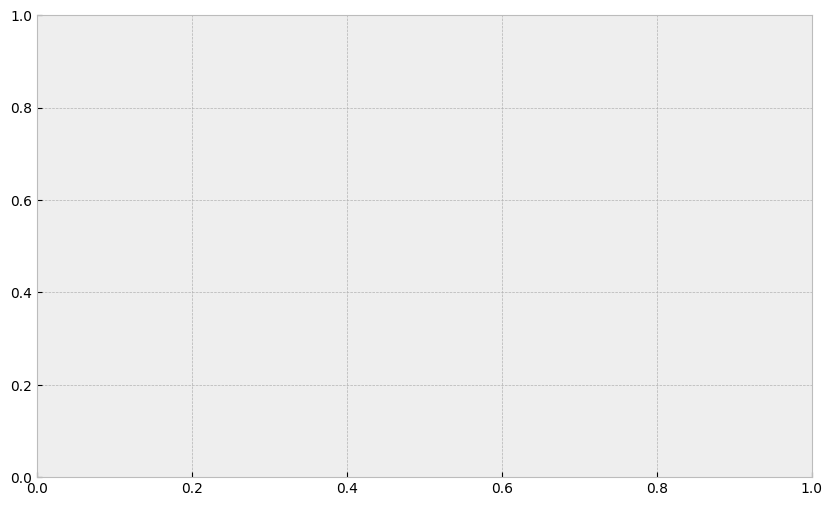

In [4]:
# renaming the dataframe for convenience
target = "pahosp1y"

# plottiing the unique values of the target to spot imbalance}
with plt.style.context('bmh'):
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x=target, data=df, linewidth=0)
        ax.set_xlabel("Target")
        ax.set_ylabel("Count")
        ax.set_title("Target Distribution")
        plt.show()

## 2.2. Missing values.

Number of features: 442


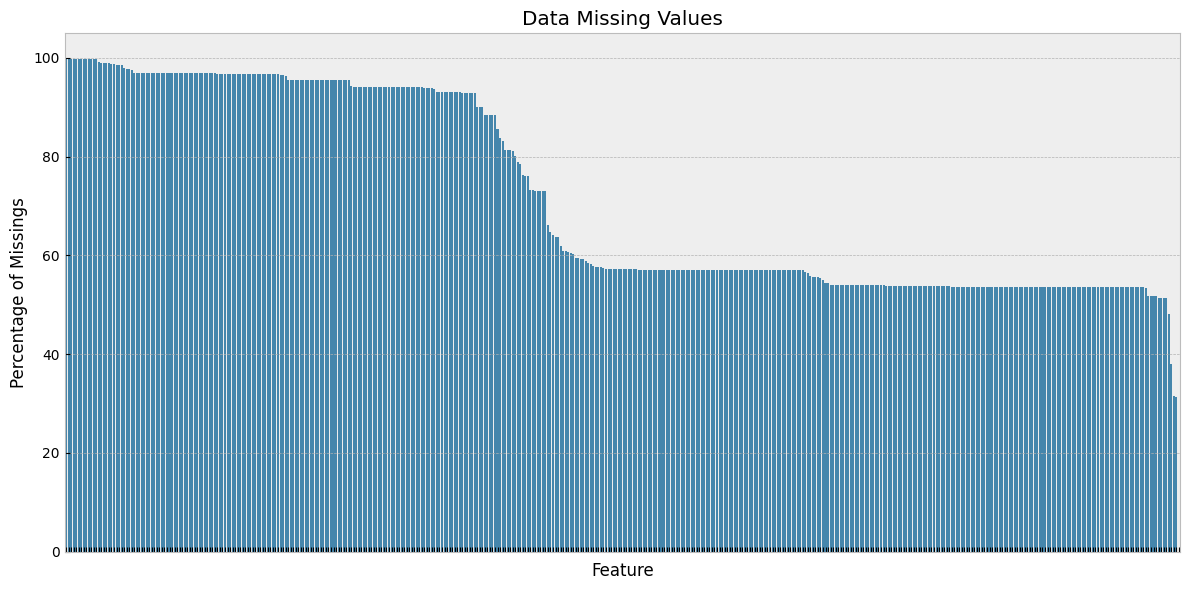

In [5]:
print(f"Number of features: {df.shape[1]}")
plot_missing_values(df)

## 2.3. Data type and unique values.
* Data consists primarily of binary, discrete, and, to a lesser extent, continuous data.

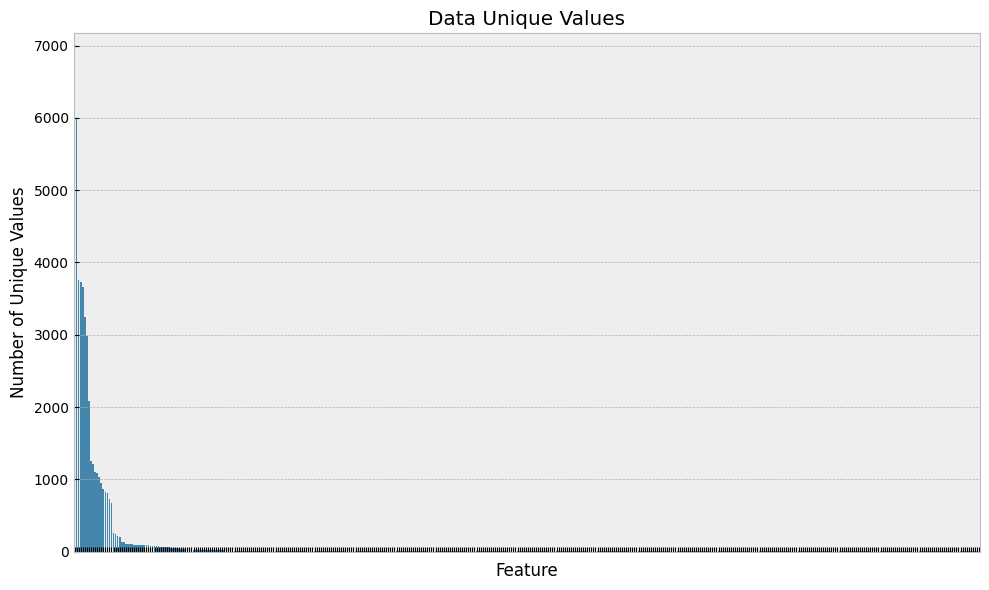

In [6]:
plot_uniques(df)

## 2.4. Correlation between binary features and the target.

* A clear relationship between the characteristics and the target variables is observed by Cramer's V. This statistic is a measure of effect size for the chi-squared test of independence. It measures how two categorical fields are related.

Effect Size (ES) / Interpretation

ES ≤ 0.2 The result is weak. Although the result is statistically significant, the fields are only weakly associated.

0.2 < ES ≤ 0.6 The result is moderate. The fields are moderately related.

**ES > 0.6 The result is strong. The fields are strongly associated.**

/home/giraldiego/Desktop/code/workspaces/anyoneai/final_project/Final_Projects/src/eda.py:208: RuntimeWarning: invalid value encountered in scalar divide
  V = np.sqrt(phi_c / min(contingency_table.shape[0] - 1, contingency_table.shape[1] - 1))
/home/giraldiego/Desktop/code/workspaces/anyoneai/final_project/Final_Projects/src/eda.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Correlation", y="Column", data=corr_df, palette="viridis")


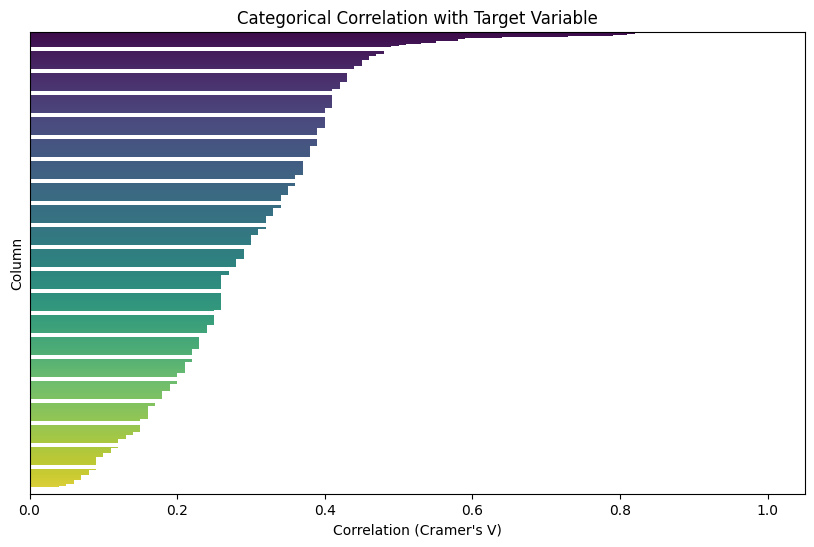

In [7]:
plot_categorical_correlation(df, target)

# 3. Model


In [518]:
# filtering the data by elderly people only.
df = df.loc[df['paagey']>=50]

# The selected features, we believe are relevant to the model.
selected=['pahosp1y','pahip50e', 'padadage', 'pamomage', 
          'pahibpe', 'parespe', 'pacholst', 'pagrossaa', 
          'paosleep', 'pafallinj', 'pacancre', 'paswell', 
          'parafaany', 'pawheeze', 'paagey', 
          'paarthre', 'padiabe', 'parjudg', 'paweight', 
          'paclims', 'pastroke', 'pasmokev', 
          'pahearaid', 'pameds', 'paheight', 'paglasses', 
          'paeat', 'papaina', 'pagender', 'padrinkb']

print(f"There are {len(selected)} features selected")

df3 = df.where(df['cpindex'] <=  109).dropna(subset=['cpindex'])

df_s = df3.dropna(subset=[target]) 
df_s = df_s[selected].copy()

nulls_percentage = df_s.isnull().sum(axis=1) / len(df.columns)
df_s = df_s[(df_s[target] != 0) | (nulls_percentage <= 0.5)]

# splitting the data into X and y
y = df_s[target]
X = df_s.drop(target,axis=1)


There are 30 features selected


In [519]:
import importlib
importlib.reload(fs)

<module 'src.feature_selection' from '/home/giraldiego/Desktop/code/workspaces/anyoneai/final_project/Final_Projects/src/feature_selection.py'>

In [520]:
X_single = X.iloc[0:1].copy()
X_single

,pahip50e,padadage,pamomage,pahibpe,parespe,pacholst,pagrossaa,paosleep,pafallinj,pacancre,...,pastroke,pasmokev,pahearaid,pameds,paheight,paglasses,paeat,papaina,pagender,padrinkb
0,1.0,78.0,60.0,1.0,0.0,1.0,0.0,NaN,1.0,0.0,...,0.0,1.0,0.0,0.0,1.73,0.0,NaN,0.0,1.0,0.0


In [521]:
#filling thge nulls
X_single_imputed = fs.fast_fill(X_single)
X_single_imputed = X_single_imputed.sort_index(axis=1)
X_single_imputed

,paagey,paarthre,pacancre,pacholst,paclims,padadage,padiabe,padrinkb,paeat,pafallinj,...,paosleep,papaina,parafaany,parespe,parjudg,pasmokev,pastroke,paswell,paweight,pawheeze
0,59.0,-1.0,-1.0,1.0,0.0,78.0,-1.0,-1.0,NaN,1.0,...,NaN,-1.0,0.0,-1.0,NaN,1.0,-1.0,-1.0,87.0,1.0


In [522]:
X = fs.fast_fill(X)
X = X.sort_index(axis=1)

In [523]:
X_single_train = X.iloc[0:1]
X_single_train

,paagey,paarthre,pacancre,pacholst,paclims,padadage,padiabe,padrinkb,paeat,pafallinj,...,paosleep,papaina,parafaany,parespe,parjudg,pasmokev,pastroke,paswell,paweight,pawheeze
0,59.0,-1.0,-1.0,1.0,0.0,78.0,-1.0,-1.0,0.056752,1.0,...,2.527403,-1.0,0.0,-1.0,3.278509,1.0,-1.0,-1.0,87.0,1.0


In [213]:
X = fs.fast_fill(X)
X = X.sort_index(axis=1)

# Scaling the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalizing the data
transformer = PowerTransformer(method='yeo-johnson')
X = transformer.fit_transform(X)

# w1 63.30
# w2 73.90
# w3 107.70
# w4 119.40
# w5 136.60
X.shape 

(68619, 29)

In [9]:
# creating variables that captures the proportion of classes in the target.
zeros=y.value_counts()[0]
ones=y.value_counts()[1]

# This are the parameters that we found to be the best for the model.
params={
        'max_depth': 8, 
        'subsample': 0.759545947005226,
        'colsample_bytree': 0.9075616505206274, 
        'eta': 0.07568753700048324, 
        'min_child_weight': 5, 
        'n_estimators': 561, 
        'scale_pos_weight': (zeros/ones)-2.5,
        'n_jobs':-1,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
}

# instantiating the model
model = XGBClassifier(**params)

# 4. Evaluation

In [10]:
kf = KFold(n_splits=7)

y_test_all = []
y_pred_all = []
y_pred_prob_all = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)], 
            early_stopping_rounds=3) 
    
    y_test_all.extend(y_test)
    y_pred_all.extend(model.predict(X_test))
    y_pred_prob_all.extend(model.predict_proba(X_test))

/opt/.pyenv/versions/3.10.13/envs/ne1ai-project/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.56062	validation_1-logloss:0.55869
[1]	validation_0-logloss:0.54962	validation_1-logloss:0.54736
[2]	validation_0-logloss:0.53959	validation_1-logloss:0.53727
[3]	validation_0-logloss:0.53008	validation_1-logloss:0.52699
[4]	validation_0-logloss:0.52169	validation_1-logloss:0.51828
[5]	validation_0-logloss:0.51401	validation_1-logloss:0.51070
[6]	validation_0-logloss:0.50697	validation_1-logloss:0.50387
[7]	validation_0-logloss:0.50051	validation_1-logloss:0.49731
[8]	validation_0-logloss:0.49509	validation_1-logloss:0.49193
[9]	validation_0-logloss:0.48899	validation_1-logloss:0.48601
[10]	validation_0-logloss:0.48402	validation_1-logloss:0.48167
[11]	validation_0-logloss:0.47949	validation_1-logloss:0.47760
[12]	validation_0-logloss:0.47574	validation_1-logloss:0.47405
[13]	validation_0-logloss:0.47155	validation_1-logloss:0.47027
[14]	validation_0-logloss:0.46760	validation_1-logloss:0.46611
[15]	validation_0-logloss:0.46395	validation_1-logloss:0.46297
[1

In [11]:
# Convertir las listas en arrays numpy
y_test_all = np.array(y_test_all)
y_pred_all = np.array(y_pred_all)
y_pred_prob_all = np.array(y_pred_prob_all)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_test_all, y_pred_prob_all)

# Calcular el classification_report
report = classification_report(y_test_all, y_pred_all)

print(f'AUC: {auc}')
print(f'F1: {f1_score(y_test_all, y_pred_all)}')
print(report)

AUC: 0.9354377954643636
F1: 0.780795015913862
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     61314
         1.0       0.77      0.79      0.78      7305

    accuracy                           0.95     68619
   macro avg       0.87      0.88      0.88     68619
weighted avg       0.95      0.95      0.95     68619



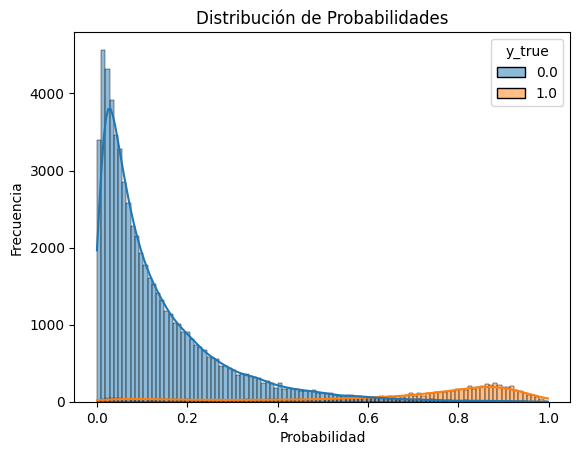

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un DataFrame con las etiquetas de prueba y las probabilidades predichas
data = pd.DataFrame({'y_true': y_test_all, 'y_pred_prob': y_pred_prob_all})

# Graficar la distribución de probabilidades
sns.histplot(data=data, x='y_pred_prob', hue='y_true', kde=True)

# Agregar etiquetas y título al gráfico
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades')

# Mostrar el gráfico
plt.show()

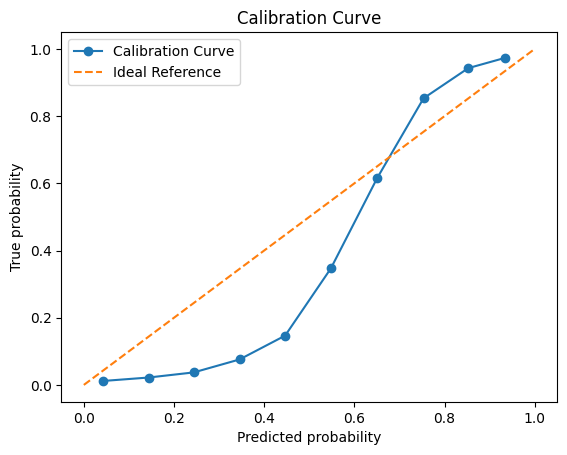

In [13]:
from sklearn.calibration import calibration_curve
# Calcular la curva de calibración
prob_true, prob_pred = calibration_curve(y_test_all, y_pred_prob_all, n_bins=10)

# Graficar la curva de calibración
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Calibration Curve')

# Graficar la línea de referencia ideal
plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal Reference')

# Configurar los ejes y la leyenda
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve')
plt.legend()

# Mostrar el gráfico
plt.show()

# 5. Exporting the model

## Saving the model

In [399]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9075616505206274, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.07568753700048324, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=561,
              n_jobs=-1, num_parallel_tree=None, ...)

In [19]:
# This function acts as a Vectorizer and Imputer of the dataframe
# fs.fast_fill

<function src.feature_selection.fast_fill(dataframe: pandas.core.frame.DataFrame)>

In [402]:
# scaler, transformer
transformers = {"imputer":fs.fast_fill, "scaler":scaler, "transformer":transformer}
transformers

{'imputer': <function src.feature_selection.fast_fill(dataframe: pandas.core.frame.DataFrame)>,
 'scaler': StandardScaler(),
 'transformer': PowerTransformer()}

In [403]:
import pickle

model_type = "XGBClassifier_model" # This is the name for the filename of the model

output_file = f"hospitalization-{model_type}.bin"

with open(output_file, "wb") as f_out:
    pickle.dump((transformers, model), f_out)


## Load the model (Testing)

In [524]:
import pickle

input_file = f"hospitalization-{model_type}.bin" # Use the same name than above

with open(input_file, "rb") as f_in:
    transformers_imported, model_imported = pickle.load(f_in)

transformers_imported, model_imported

({'imputer': <function src.feature_selection.fast_fill(dataframe: pandas.core.frame.DataFrame)>,
  'scaler': StandardScaler(),
  'transformer': PowerTransformer()},
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9075616505206274, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eta=0.07568753700048324, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
               max_leaves=None, min_child_weight=5, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=561,
               n_jobs=-1, num_parallel_tree=None, ...))

In [525]:
# Import transformer objects from pickle
imputer_imported = transformers_imported["imputer"]
scaler_imported = transformers_imported["scaler"]
transformer_imported = transformers_imported["transformer"]

In [526]:
df_s[df_s["pahosp1y"] == 1].head()

,pahosp1y,pahip50e,padadage,pamomage,pahibpe,parespe,pacholst,pagrossaa,paosleep,pafallinj,...,pastroke,pasmokev,pahearaid,pameds,paheight,paglasses,paeat,papaina,pagender,padrinkb
0,1.0,1.0,78.0,60.0,1.0,0.0,1.0,0.0,NaN,1.0,...,0.0,1.0,0.0,0.0,1.73,0.0,NaN,0.0,1.0,0.0
18,1.0,0.0,70.0,NaN,1.0,0.0,0.0,0.0,NaN,1.0,...,1.0,1.0,0.0,0.0,NaN,0.0,0.0,1.0,2.0,0.0
75,1.0,1.0,77.0,70.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0.0,1.0,0.0,0.0,1.60,0.0,0.0,1.0,1.0,0.0
76,1.0,0.0,83.0,72.0,0.0,0.0,1.0,1.0,NaN,1.0,...,0.0,0.0,0.0,0.0,1.30,0.0,0.0,0.0,2.0,0.0
78,1.0,1.0,NaN,80.0,1.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,2.0,0.0


In [563]:
pos = 0 # change this number to extract a different patient

y_patient = df_s["pahosp1y"].iloc[pos]
print(y_patient) # Print it the patient was hospitalizated 

# Convert patient to dict similar to format of the json in the api
patient_dict = df_s.drop(target, axis=1).iloc[pos].to_dict()
print(patient_dict)

1.0
{'pahip50e': 1.0, 'padadage': 78.0, 'pamomage': 60.0, 'pahibpe': 1.0, 'parespe': 0.0, 'pacholst': 1.0, 'pagrossaa': 0.0, 'paosleep': nan, 'pafallinj': 1.0, 'pacancre': 0.0, 'paswell': 0.0, 'parafaany': nan, 'pawheeze': 1.0, 'paagey': 59.0, 'paarthre': 0.0, 'padiabe': 0.0, 'parjudg': nan, 'paweight': 87.0, 'paclims': 0.0, 'pastroke': 0.0, 'pasmokev': 1.0, 'pahearaid': 0.0, 'pameds': 0.0, 'paheight': 1.7300000190734863, 'paglasses': 0.0, 'paeat': nan, 'papaina': 0.0, 'pagender': 1.0, 'padrinkb': 0.0}


In [552]:
df_patient = pd.Series(patient_dict).to_frame().T
df_patient # This is the one generated from a dictionary

,pahip50e,padadage,pamomage,pahibpe,parespe,pacholst,pagrossaa,paosleep,pafallinj,pacancre,...,pastroke,pasmokev,pahearaid,pameds,paheight,paglasses,paeat,papaina,pagender,padrinkb
0,0.0,70.0,NaN,1.0,0.0,0.0,0.0,NaN,1.0,0.0,...,1.0,1.0,0.0,0.0,NaN,0.0,0.0,1.0,2.0,0.0


In [553]:
# df_patient = X_single.copy()

In [554]:
def fill_with_encoding(dataframe, columns):
    # Reemplazar los 0 por -1
    dataframe[columns] = dataframe[columns].replace(0, -1)
    dataframe[columns] = dataframe[columns].fillna(0)

    return dataframe[columns]

def fill_with_mean(dataframe, columns):
    for column in columns:
        # mean = dataframe[column].mean()
        # dataframe[column].fillna(mean, inplace=True)
        dataframe[column].fillna(0)

    return dataframe[columns]

def my_fast_fill(dataframe):
    # binary_cols, non_binary_cols = get_bin_columns(dataframe)
    binary_cols = [
        "pahip50e",
        "pahibpe",
        "parespe",
        "pacholst",
        "pagrossaa",
        "pafallinj",
        "pacancre",
        "paswell",
        "parafaany",
        "pawheeze",
        "paarthre",
        "padiabe",
        "pastroke",
        "pasmokev",
        "pahearaid",
        "paglasses",
        "papaina",
        "pagender",
        "padrinkb",
    ]
    non_binary_cols = [
        "padadage",
        "pamomage",
        "paosleep",
        "paagey",
        "parjudg",
        "paweight",
        "paclims",
        "pameds",
        "paheight",
        "paeat",
    ]
    dataframe[binary_cols] = fill_with_encoding(dataframe, binary_cols)
    # dataframe[non_binary_cols] = fill_with_mean(dataframe, non_binary_cols)
    dataframe.fillna(1, inplace=True)

    return dataframe

In [555]:
# X_patient = my_fast_fill(df_patient)
X_patient_imputed = imputer_imported(df_patient)
X_patient_imputed = X_patient_imputed.sort_index(axis=1)

In [556]:
X_patient_imputed

,paagey,paarthre,pacancre,pacholst,paclims,padadage,padiabe,padrinkb,paeat,pafallinj,...,paosleep,papaina,parafaany,parespe,parjudg,pasmokev,pastroke,paswell,paweight,pawheeze
0,56.0,-1.0,-1.0,-1.0,1.0,70.0,-1.0,-1.0,0.0,1.0,...,NaN,1.0,0.0,-1.0,NaN,1.0,1.0,-1.0,80.0,1.0


In [557]:
X_single_imputed

,paagey,paarthre,pacancre,pacholst,paclims,padadage,padiabe,padrinkb,paeat,pafallinj,...,paosleep,papaina,parafaany,parespe,parjudg,pasmokev,pastroke,paswell,paweight,pawheeze
0,59.0,-1.0,-1.0,1.0,0.0,78.0,-1.0,-1.0,NaN,1.0,...,NaN,-1.0,0.0,-1.0,NaN,1.0,-1.0,-1.0,87.0,1.0


In [558]:
X_single_train

,paagey,paarthre,pacancre,pacholst,paclims,padadage,padiabe,padrinkb,paeat,pafallinj,...,paosleep,papaina,parafaany,parespe,parjudg,pasmokev,pastroke,paswell,paweight,pawheeze
0,59.0,-1.0,-1.0,1.0,0.0,78.0,-1.0,-1.0,0.056752,1.0,...,2.527403,-1.0,0.0,-1.0,3.278509,1.0,-1.0,-1.0,87.0,1.0


In [559]:
X_patient_imputed.columns == X_single_train.columns # Columns are the same

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [560]:
X_patient_proc = scaler_imported.transform(X_patient_imputed)
# X_patient_proc = scaler_imported.transform(X_patient_train)
X_patient_proc


array([[-0.76690627, -0.56299668, -0.18493027, -1.24505349, -0.11403769,
        -0.12903125, -0.51423127, -0.320201  , -0.18299221,  2.066958  ,
         0.97502718, -0.91606267, -0.63438074, -0.12486206,         nan,
         1.09689696, -0.62829461, -0.1139597 ,         nan,         nan,
         1.69171831,  0.38525293, -0.30590328,         nan,  1.17200693,
         5.39250786, -0.65388169,  0.71220975,  2.09732903]])

In [561]:
X_patient_proc = transformer_imported.transform(X_patient_proc)
X_patient_proc

array([[-0.76274561, -0.56695884, -0.19201485, -1.21242985,  0.57434886,
        -0.25972811, -0.51868154, -0.32251484, -0.87819641,  1.59074494,
         0.97502718, -0.91612353, -0.6606796 , -0.12555941,         nan,
         1.09474613, -0.6800491 , -0.34415176,         nan,         nan,
         1.69717841,  0.29624845, -0.31095537,         nan,  1.17184402,
         4.84027548, -0.67983814,  0.75755925,  1.60766269]])

In [562]:
y_pred = model.predict_proba(X_patient_proc)[0, 1]
hospitalization = y_pred >= 0.5
y_patient, hospitalization, y_pred

(1.0, False, 0.3527635)

In [507]:
def transform_data(dict_data, transformers):
    df_data = pd.Series(dict_data).to_frame().T

    imputer = transformers["imputer"]
    scaler = transformers["scaler"]
    transformer = transformers["transformer"]

    X_single = imputer(df_data)
    X_single = X_single.sort_index(axis=1)
    X_single = transformer.transform(X_single)
    X_single = scaler.transform(X_single)

    return X_single

In [508]:
def predict_single_patient(patient_dict, transformers, model):
    """
    Predicts the probability of hospitalization for a single patient.

    Parameters:
    - patient: The data of the patient to be predicted.
    - transformers: The transformers used to preprocess the data.

    Returns:
    - y_pred: The predicted probability of hospitalization.
    - hospitalization: True if the predicted probability is greater than or equal to 0.5, False otherwise.
    """
    X_patient = transform_data(patient_dict, transformers)
    y_pred = model.predict_proba(X_patient)[0, 1]
    hospitalization = y_pred >= 0.5
    return y_pred, hospitalization

In [512]:
pos = 0 # change this number to extract a different patient

y_patient = df_s["pahosp1y"].iloc[pos]
print(y_patient) # Print it the patient was hospitalizated 

# Convert patient to dict similar to format of the json in the api
patient_dict = df_s.drop(target, axis=1).iloc[pos].to_dict()
print(patient_dict)

1.0
{'pahip50e': 1.0, 'padadage': 78.0, 'pamomage': 60.0, 'pahibpe': 1.0, 'parespe': 0.0, 'pacholst': 1.0, 'pagrossaa': 0.0, 'paosleep': nan, 'pafallinj': 1.0, 'pacancre': 0.0, 'paswell': 0.0, 'parafaany': nan, 'pawheeze': 1.0, 'paagey': 59.0, 'paarthre': 0.0, 'padiabe': 0.0, 'parjudg': nan, 'paweight': 87.0, 'paclims': 0.0, 'pastroke': 0.0, 'pasmokev': 1.0, 'pahearaid': 0.0, 'pameds': 0.0, 'paheight': 1.7300000190734863, 'paglasses': 0.0, 'paeat': nan, 'papaina': 0.0, 'pagender': 1.0, 'padrinkb': 0.0}


dict_data = patient_dict
df_data = pd.Series(dict_data).to_frame().T

imputer_imported = transformers_imported["imputer"]
scaler_imported = transformers_imported["scaler"]
transformer_imported = transformers_imported["transformer"]

X_single = imputer_imported(df_data)
X_single = X_single.sort_index(axis=1)
X_single = transformer_imported.transform(X_single)
X_single = scaler_imported.transform(X_single)

X_single

In [517]:
predict_single_patient(patient_dict, transformers_imported, model_imported)

/opt/.pyenv/versions/3.10.13/envs/ne1ai-project/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
/opt/.pyenv/versions/3.10.13/envs/ne1ai-project/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(0.6682428, True)

In [511]:
transformers_imported

{'imputer': <function src.feature_selection.fast_fill(dataframe: pandas.core.frame.DataFrame)>,
 'scaler': StandardScaler(),
 'transformer': PowerTransformer()}